In [16]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad
from tqdm import tqdm
import scipy.integrate as spi
import matplotlib.pyplot as plt

In [17]:
# A is N-cycle and b is 0
def gen_energy_params(N):
    A = np.zeros((N, N))
    indices = np.arange(0, N, 1)
    targets = np.roll(indices, -1)
    A[indices,targets] = 1
    A = A + A.T
    A = jnp.array(A)
    b = jnp.zeros(N)
    return A, b

# U(x) = -beta(x.T A x + b.T x)
def gen_energy_func(A, b, beta):
    def U(x):
        return -beta * (0.5 * jnp.dot(x, jnp.matvec(A, x)) + jnp.dot(b, x))
    return U

In [18]:
from itertools import product

def calc_baseline_distribution(calc_U, N):
    sample_space = jnp.array(list(product([-1, 1], repeat=N)))
    U_vals = calc_U(sample_space)
    exp_U_vals = jnp.exp(-U_vals)
    distr = exp_U_vals / jnp.sum(exp_U_vals)
    distr_map = {}
    for i, sample in enumerate(sample_space):
        distr_map[tuple(sample.tolist())] = distr[i]
    return distr_map
    
def calc_variational_dist(samples, baseline_distr):
    assert all([tuple(k.tolist()) in baseline_distr for k in samples])
    num_samples = len(samples)
    distr_map = {k : 0.0 for k in baseline_distr}
    for sample in samples:
        key = tuple(sample.tolist())
        distr_map[key] += 1 / num_samples
    vd = sum([abs(distr_map[k]-baseline_distr[k]) for k in baseline_distr]) / 2
    return vd, distr_map

In [19]:
def sample_MuCOLA(calc_dU, proj_x, x0, iter, alpha, return_vd_traj=False, baseline_distr=None):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"

    m, N = x0.shape

    half_alpha = 0.5 * alpha
    sqrt_alpha = np.sqrt(alpha)

    zero_mean = np.zeros(N)
    id_cov = np.identity(N)

    x_curr = x0

    vd_traj = []
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    for _ in tqdm(range(iter)):
        z = np.random.multivariate_normal(zero_mean, id_cov, size=(m, ))
        x_embed = x_curr - half_alpha * calc_dU(x_curr) + sqrt_alpha * z
        x_curr = proj_x(x_embed)
        
        if return_vd_traj:
            vd, _ = calc_variational_dist(np.array(x_curr), baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr

In [20]:
def proj_x(x):
    x = np.sign(x)
    x[x==0] = 1
    return jnp.array(x)

In [241]:
m = 10000
iter = 25
N = 9
beta = 0.42
A, b = gen_energy_params(N)
U_func = gen_energy_func(A, b, beta)
calc_U = jax.jit(jax.vmap(U_func))
calc_dU = jax.jit(jax.vmap(jax.grad(U_func)))

baseline_distr = calc_baseline_distribution(calc_U, N)

100%|██████████| 25/25 [00:01<00:00, 14.17it/s]


0.1830969


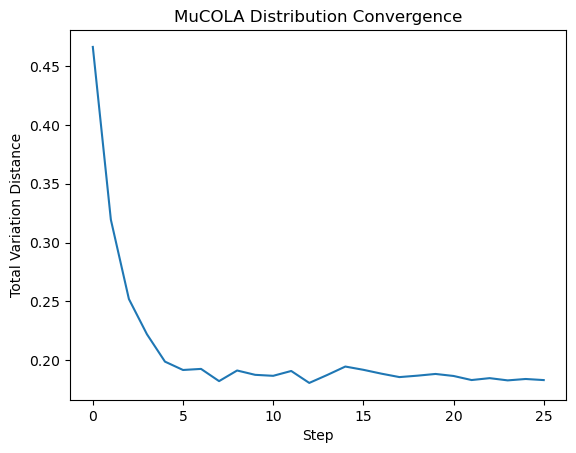

In [242]:
alpha = 1.5
x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding
x0 = jnp.array(x0)

samples, vd_traj = sample_MuCOLA(calc_dU, proj_x, x0, iter, alpha, return_vd_traj=True, baseline_distr=baseline_distr)
vd, distr_map = calc_variational_dist(samples, baseline_distr)
print(vd)

plt.plot(vd_traj)
plt.title("MuCOLA Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.show()

In [243]:
def sample_MH(calc_U, x0, iter, return_vd_traj=False, baseline_distr=None):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"

    m, N = x0.shape
    x_curr = jnp.array(x0)

    U_curr = calc_U(x_curr)

    vd_traj = []
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    for _ in tqdm(range(iter)):
        x_prop = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32)
        U_prop = calc_U(x_prop)

        log_accept_ratio = -(U_prop - U_curr)
        accept = np.log(np.random.uniform(size=(m,))) < log_accept_ratio

        accept = accept[:, None]
        x_curr = np.where(accept, x_prop, x_curr)
        U_curr = np.where(accept.squeeze(), U_prop, U_curr)

        if return_vd_traj:
            vd, _ = calc_variational_dist(x_curr, baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr


In [ ]:
x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding
x0 = jnp.array(x0)

samples_mh, vd_traj_mh = sample_MH(calc_U, x0, iter, return_vd_traj=True, baseline_distr=baseline_distr)
vd_mh, distr_map_mh = calc_variational_dist(samples_mh, baseline_distr)
print(vd_mh)

plt.plot(vd_traj_mh)
plt.title("Metropolis-Hastings Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.show()

 64%|██████▍   | 16/25 [00:00<00:00, 16.40it/s]

In [ ]:
def sample_pNCG(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=False, baseline_distr=None):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"

    m, N = x0.shape # THIS ASSUMES EMBEDDING DIM = 1

    half_inv_alpha = 1 / (2 * alpha)

    x_curr = jnp.array(x0)

    vd_traj = []
    
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    vocab_array = jnp.stack(vocab)  # shape (vocab_size, embedding_dim)

    key = jax.random.PRNGKey(0)

    def calc_stats(x):
        U = calc_U(x)
        dU = calc_dU(x)
        diffs = vocab_array[None, None, :, :] - x[:, :, None, None]
        p_norms_p = jnp.linalg.norm(diffs, ord=p, axis=-1) ** p
        grad_prod = jnp.einsum("abcd,abd->abc", diffs, dU[:, :, None])
        logits = -0.5 * grad_prod - half_inv_alpha * p_norms_p
        probs = jax.nn.softmax(logits, axis=-1)
        
        return U, dU, logits, probs
    
    def calc_prob_gen(indices, probs):
        prop_probs = probs[jnp.arange(m)[:, None], jnp.arange(N), indices]
        total_prob = jnp.prod(prop_probs, axis=-1)
        return total_prob

    curr_U, curr_dU, curr_logits, curr_probs = calc_stats(x_curr)
    curr_indices = ((x0 + 1).squeeze() // 2).astype(int) # [-1, 1] => [0, 1]

    for _ in tqdm(range(iter)):
        flat_logits = curr_logits.reshape(-1, curr_logits.shape[-1])

        key, subkeys_key = jax.random.split(key)
        subkeys = jax.random.split(subkeys_key, m * N)
        samples_flat = jax.vmap(
            lambda k, l: jax.random.categorical(k, l)
        )(subkeys, flat_logits)

        samples = samples_flat.reshape(m, N) 
        x_prop = np.array(vocab)[samples].squeeze()

        prop_U, prop_dU, prop_logits, prop_probs = calc_stats(x_prop)
        
        gen_prob = calc_prob_gen(samples, curr_probs)
        rev_gen_prob = calc_prob_gen(curr_indices, prop_probs)

        key, subkey = jax.random.split(key)
        accept_prob = jnp.exp(curr_U - prop_U) * rev_gen_prob / gen_prob
        accept = (accept_prob > jax.random.uniform(subkey, shape=(m,))).astype(int)
        x_curr = np.where(accept[:, None], x_prop, x_curr) # type: ignore
        curr_U = np.where(accept, prop_U, curr_U) # type: ignore
        curr_dU = np.where(accept[:, None], prop_dU, curr_dU) # type: ignore
        curr_logits = np.where(accept[:, None, None], prop_logits, curr_logits) # type: ignore
        curr_probs = np.where(accept[:, None, None], prop_probs, curr_probs) # type: ignore
        curr_indices = np.where(accept[:, None], samples, curr_indices) # type: ignore

        if return_vd_traj:
            vd, _ = calc_variational_dist(x_curr, baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr

x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding
x0 = jnp.array(x0)

alpha = 1.0
vocab = [np.array([-1.0]), np.array([1.0])]
samples_ncg, vd_traj_ncg = sample_pNCG(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=True, baseline_distr=baseline_distr)
vd_ncg, distr_map_ncg = calc_variational_dist(samples_ncg, baseline_distr)
print(vd_ncg)

100%|██████████| 25/25 [00:01<00:00, 15.15it/s]

0.054566704


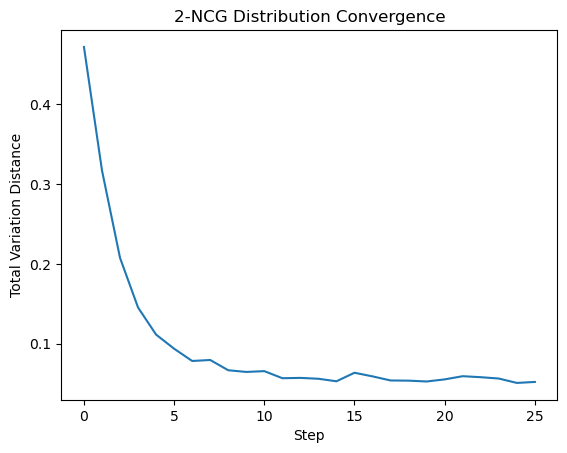

In [ ]:
plt.plot(vd_traj_ncg)
plt.title("2-NCG Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.show()

In [ ]:
def sample_gwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=False, baseline_distr=None):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"

    m, N = x0.shape # THIS ASSUMES EMBEDDING DIM = 1

    x_curr = x0.copy()
    
    vd_traj = []
    
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    key = jax.random.PRNGKey(0)

    curr_U = calc_U(x_curr)
    
    for _ in tqdm(range(iter)):
        key, subkey = jax.random.split(key)
        subkey1, subkey2 = jax.random.split(subkey, 2)

        target_j = np.array(jax.random.choice(subkey1, jnp.arange(0, N, 1), shape=(m,)))

        x_prop = x_curr.copy()
        x_prop[np.arange(0, m, 1), target_j] *= -1

        prop_U = calc_U(x_prop)
        
        accept_prob = jnp.exp(curr_U - prop_U)
        accept = (accept_prob > jax.random.uniform(subkey2, shape=(m,))).astype(int)
        x_curr = np.where(accept[:, None], x_prop, x_curr) # type: ignore
        curr_U = np.where(accept, prop_U, curr_U) # type: ignore

        if return_vd_traj:
            vd, _ = calc_variational_dist(x_curr, baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr

x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding

alpha = 1.0
vocab = [np.array([-1.0]), np.array([1.0])]
samples_gwl, vd_traj_gwl = sample_gwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=True, baseline_distr=baseline_distr)
vd_gwl, distr_map_gwl = calc_variational_dist(samples_gwl, baseline_distr)
print(vd_gwl)

100%|██████████| 25/25 [00:01<00:00, 19.52it/s]

0.056156643


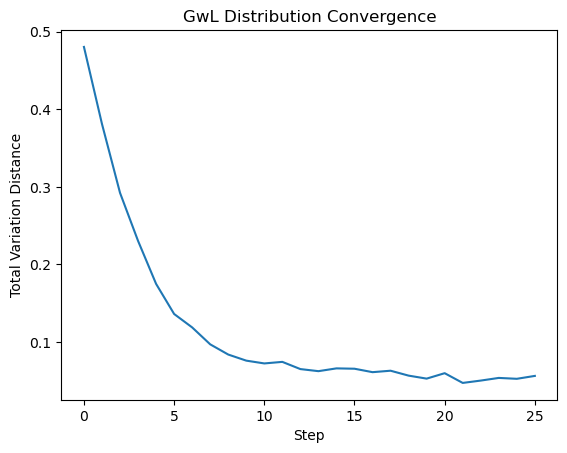

In [ ]:
plt.plot(vd_traj_gwl)
plt.title("GwL Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.show()

In [ ]:
import scipy

# Interaction-Gibbs-With-Langevin
def sample_igwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=False, baseline_distr=None, order=2):
    assert not return_vd_traj or baseline_distr is not None, "To get vd traj, you must pass in the baseline distribution map"

    m, N = x0.shape # THIS ASSUMES EMBEDDING DIM = 1

    x_curr = x0.copy()#jnp.array(x0)
    vocab_array = np.stack(vocab)  # shape (vocab_size, embedding_dim)

    inv_alpha = 1 / alpha

    def zero_logit_loops(targets, indices, logits):
        g_idx = np.arange(m)
        site_idx = targets[:, -1]
        logits[g_idx, site_idx, indices[g_idx, site_idx]] = -np.inf
        return logits
    
    def calc_stats(x):
        U = calc_U(x)
        dU = np.array(calc_dU(x))
        diffs = vocab_array[None, None, :, :] - x[:, :, None, None]
        p_norms_p = np.linalg.norm(diffs, ord=p, axis=-1) ** p
        grad_prod = np.einsum("abcd,abd->abc", diffs, dU[:, :, None])
        logits = -grad_prod - inv_alpha * p_norms_p

        return U, dU, logits
    
    def calc_prob_gen(indices, prev_indices, targets, logits):

        # Make self loops impossible for the last target
        logits = zero_logit_loops(targets, prev_indices, logits)

        prop_logits = logits[np.arange(m)[:, None], targets]
        probs = scipy.special.softmax(prop_logits, axis=-1)
        target_indices = indices[np.arange(m)[:, None], targets]
        prop_probs = probs[np.arange(m)[:, None], np.arange(order), target_indices]
        total_prob = np.prod(prop_probs, axis=-1)
        return total_prob

    vd_traj = []
    
    if return_vd_traj:
        vd, _ = calc_variational_dist(x_curr, baseline_distr)
        vd_traj.append(vd)

    key = jax.random.PRNGKey(0)

    curr_indices = ((x0 + 1).squeeze() // 2).astype(int) # [-1, 1] => [0, 1]
    curr_U, curr_dU, curr_logits = calc_stats(x_curr)

    for _ in tqdm(range(iter)):

        key, subkey = jax.random.split(key)

        # flip_targets = jax.random.choice(subkey, jnp.arange(0, N, 1), shape=(m * order, )).reshape(m, order)
        subkeys = jax.random.split(subkey, m)
        flip_targets = np.array(jax.vmap(
            lambda k: jax.random.choice(
                k,
                N,
                shape=(order,),
                replace=False
            )
        )(subkeys))   # shape (m, order)

        tmp_logits = zero_logit_loops(flip_targets, curr_indices, curr_logits.copy())
        flat_logits = tmp_logits[np.arange(m)[:, None], flip_targets].reshape(-1, tmp_logits.shape[-1]) # (a, b), (a, c, d) => (a, b, d)

        key, subkeys_key = jax.random.split(key)
        subkeys = jax.random.split(subkeys_key, m * order)
        samples_flat = np.array(jax.vmap(
            lambda k, l: jax.random.categorical(k, l)
        )(subkeys, flat_logits))

        samples = samples_flat.reshape(m, order)
        x_prop = np.array(x_curr)
        x_prop[np.arange(m)[:, None], flip_targets] = np.array(vocab)[samples].reshape((m, -1))
        prop_indices = np.array(curr_indices)
        prop_indices[np.arange(m)[:, None], flip_targets] = samples

        prop_U, prop_dU, prop_logits = calc_stats(x_prop)
        
        gen_prob = calc_prob_gen(prop_indices, curr_indices, flip_targets, curr_logits.copy())
        rev_gen_prob = calc_prob_gen(curr_indices, prop_indices, flip_targets, prop_logits.copy())

        key, subkey = jax.random.split(key)
        accept_prob = np.exp(curr_U - prop_U) * rev_gen_prob / gen_prob
        accept = np.array((accept_prob > jax.random.uniform(subkey, shape=(m,)))).astype(int)
        x_curr = np.where(accept[:, None], x_prop, x_curr) # type: ignore
        curr_U = np.where(accept, prop_U, curr_U) # type: ignore
        curr_dU = np.where(accept[:, None], prop_dU, curr_dU) # type: ignore
        curr_logits = np.where(accept[:, None, None], prop_logits, curr_logits) # type: ignore
        curr_indices = np.where(accept[:, None], prop_indices, curr_indices) # type: ignore

        if return_vd_traj:
            vd, _ = calc_variational_dist(x_curr, baseline_distr)
            vd_traj.append(vd)

    if return_vd_traj:
        return x_curr, vd_traj
    return x_curr


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00, 10.66it/s]


0.05431507


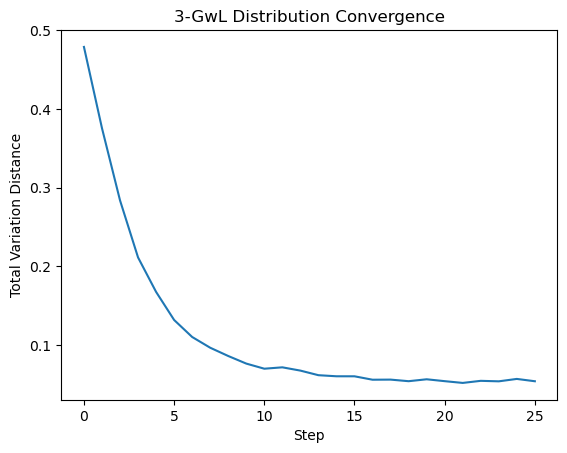

In [ ]:
x0 = np.random.choice(a=[-1, 1], size=(m, N), p=[0.5, 0.5]).astype(np.float32) # Initialize with uniform boolean embedding

order = 3
alpha = 1.0
vocab = [np.array([-1.0]), np.array([1.0])]
samples_2gwl, vd_traj_2gwl = sample_igwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=True, baseline_distr=baseline_distr, order=order)
vd_2gwl, distr_map_2gwl = calc_variational_dist(samples_2gwl, baseline_distr)

print(vd_2gwl)
plt.plot(vd_traj_2gwl)
plt.title(f"{order}-GwL Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")
plt.xticks(np.arange(0, iter + 1, 5))

plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00, 12.43it/s]


0.050290465


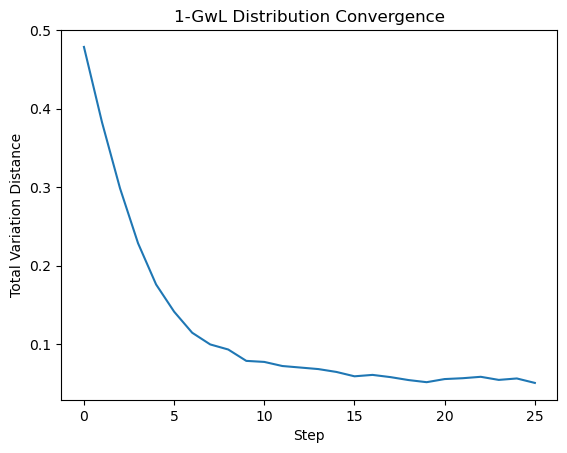

In [ ]:
order = 1
samples_1gwl, vd_traj_1gwl = sample_igwl(calc_U, calc_dU, x0, iter, alpha, vocab, p=2, return_vd_traj=True, baseline_distr=baseline_distr, order=order)
vd_1gwl, distr_map_1gwl = calc_variational_dist(samples_1gwl, baseline_distr)

print(vd_1gwl)
plt.plot(vd_traj_1gwl)
plt.title(f"{order}-GwL Distribution Convergence")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")
plt.xticks(np.arange(0, iter + 1, 5))

plt.show()

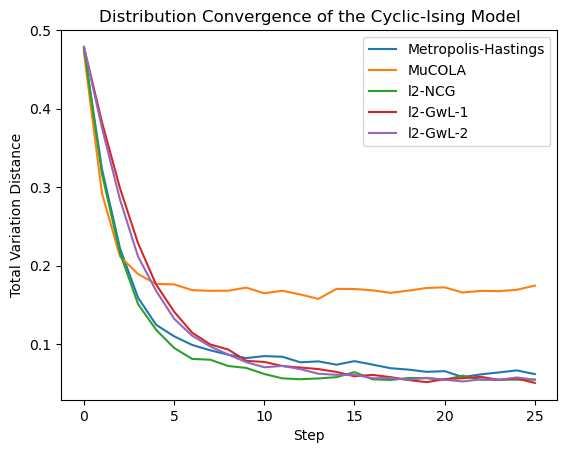

In [ ]:
graph_n = 50

plt.plot(vd_traj_mh[:graph_n], label='Metropolis-Hastings')
plt.plot(vd_traj[:graph_n], label='MuCOLA')
plt.plot(vd_traj_ncg[:graph_n], label='l2-NCG')
plt.plot(vd_traj_1gwl[:graph_n], label='l2-GwL-1')
plt.plot(vd_traj_2gwl[:graph_n], label='l2-GwL-2')
plt.title("Distribution Convergence of the Cyclic-Ising Model")
plt.xlabel("Step")
plt.ylabel("Total Variation Distance")

plt.legend()
plt.show()

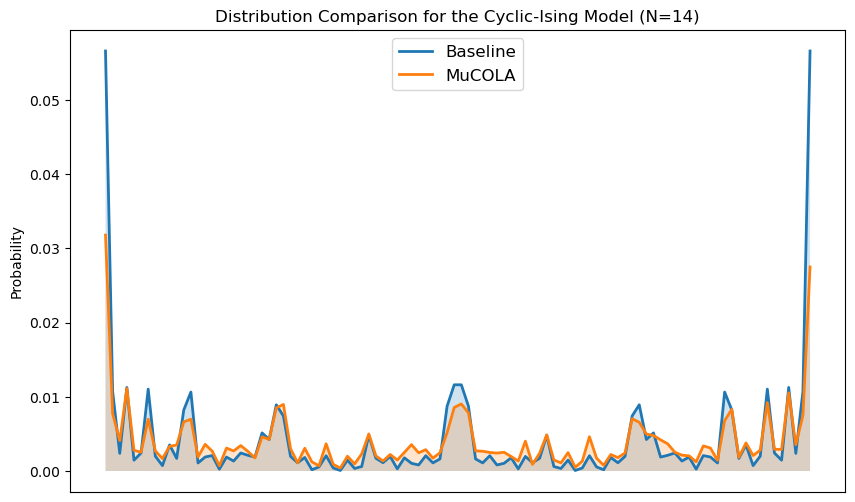

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.interpolate import make_interp_spline

# Example categorical distributions
x = np.arange(len(baseline_distr))
baseline_values = np.array(list(baseline_distr.values()))
sample_values = np.array(list(distr_map.values()))

# Create smooth x-axis for interpolation
x_smooth = np.linspace(x.min(), x.max(), 100)

# Interpolate baseline and sample distributions
baseline_smooth = make_interp_spline(x, baseline_values)(x_smooth)
sample_smooth = make_interp_spline(x, sample_values)(x_smooth)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_smooth, y=baseline_smooth, label='Baseline', linewidth=2)
sns.lineplot(x=x_smooth, y=sample_smooth, label='MuCOLA', linewidth=2)

plt.fill_between(x_smooth, baseline_smooth, alpha=0.2)
plt.fill_between(x_smooth, sample_smooth, alpha=0.2)

plt.xticks([])
plt.ylabel("Probability")
plt.title("Distribution Comparison for the Cyclic-Ising Model (N=14)")
plt.legend(fontsize=12)
plt.show()
